In [1]:
from selenium.common.exceptions import NoSuchWindowException
from selenium import webdriver
from selenium.webdriver import ActionChains as AC
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait

from pandas import Series,DataFrame
from bs4 import BeautifulSoup as bs
import pandas as pd
import numpy as np
import random

import csv

from time import sleep
import re

In [2]:
import keras
from keras import models
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras import backend as K

from keras import layers
from keras.layers import Layer
from keras.layers import Input,Dense,Flatten,Embedding,Permute,Dot,Reshape
from keras.layers.convolutional import Conv1D,MaxPooling1D,MaxPooling2D
from keras.layers import Dropout
from keras.layers import LSTM,GRU


import time

from keras.callbacks import Callback

from keras.preprocessing import sequence
from keras.utils import np_utils

import tensorflow as tf
from tensorflow.python.framework import function
import math

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import roc_auc_score,accuracy_score

import scipy
from scipy.sparse import dok_matrix

import pandas as pd
from pandas import DataFrame, Series
import numpy as np
from scipy import stats

import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

import copy

from konlpy.tag import Okt
from konlpy.tag import Komoran
from konlpy.tag import Kkma

Okt = Okt()
Kom = Komoran()
Kkma = Kkma()

Using TensorFlow backend.


In [2]:
keras.__version__

'2.3.1'

## 1. 데이터 준비 및 EDA

### 1) 데이터 LOAD

In [3]:
import os

list_dir = os.listdir("C:/Users/23/Desktop/Project/코로나/데이터/")
file_list = np.array(list_dir)[np.where(DataFrame(list(Series(list_dir).apply(lambda x : x.split("."))))[[3]] == "txt")[0]]

In [4]:

rawdata = DataFrame()

for i in file_list:
    texts = Series()
    with open("C:/Users/23/Desktop/Project/코로나/데이터/" + str(i) ,encoding = "utf-8") as text:
        for line in text:
            texts = pd.concat([texts, Series(line).str.rsplit("\t")])
            columns = ["DATE", "PRESS", "TITLE", "TEXT"]
            col_length = DataFrame(list(pd.concat([texts, Series(line).str.rsplit("\t")]))).shape[1]
            columns.extend([i for i in range(0 , (col_length - 4))])
        texts = DataFrame(list(texts.reset_index(drop = True)),columns = columns).iloc[:,0:4]
        rawdata = pd.concat([rawdata, texts])

C:\Users\23\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


In [5]:
text = rawdata["TEXT"]

In [6]:
target = rawdata["TITLE"]

In [7]:
texts_for_vocabulary = pd.concat([text,target])
##texts_for_vocuabulary= text

### 2) EDA

## 2. 데이터 전처리

In [8]:
def vect_tokenizer(text):
    return Kom.nouns(text)

### 1) 색인사전 구성

In [9]:
text = texts_for_vocabulary

In [10]:
## CountVectorizer로 문자 : 숫자로 이루어진 색인 사전을 만든다.
## 이미 만들어진 색인사전을 이용해도 됩니다.

zero_or_one = input("있는 색인사전을 쓸까요(0), 아님 신규로 만들까요(1)")

if zero_or_one == "1":
    vect = CountVectorizer(tokenizer = vect_tokenizer ,min_df = 1, analyzer = "word")
    vect.fit(text)
    vocabulary = vect.vocabulary_
    vocabulary['CLS'] = len(vocabulary) + 1
    vocabulary['EOS'] = len(vocabulary) + 1
    DataFrame([vect.vocabulary_]).to_csv("색인사전.csv",encoding="utf-8",index=False)
if zero_or_one == "0":
    vocabulary = pd.read_csv("색인사전.csv",engine="python",encoding="utf-8")
    vocabulary = vocabulary.to_dict(orient="records")[0]

있는 색인사전을 쓸까요(0), 아님 신규로 만들까요(1)0


### 2) 문장  토큰화

In [11]:
zero_or_one = input("있는 벡터화 쓸까요(0), 아님 신규로 만들까요(1)")

morphsVectored = list()

if zero_or_one == "1":

    ## 다시 형태소 분석기를 돌려서, text의 문장을 형태소로 분해하여 morphs에 담는다.
    ## 시간이 오래 걸립니다. 5분정도

    morphs = list()

    for i in text:
        temp = Kom.nouns(i)
        temp.insert(0,'CLS')
        temp.append("EOS")
        morphs.append(temp)
        
    for i in morphs:
        temporailyList = list()
        for k in i:
            #print(k)
            try:
                temporailyList.append(vocabulary[k])
            except KeyError:
                temporailyList.append(0)
        morphsVectored.append(temporailyList)

    DataFrame(morphsVectored).to_csv("벡터화.csv",index=False,encoding="utf-8")

if zero_or_one == "0" :
    morphsVectored = list()
    rawdata = pd.read_csv("벡터화.csv",engine="python",encoding =" utf-8")

    for i in range(0,len(rawdata)):
        morphsVectored.append(list(rawdata.loc[i,:].dropna()))

있는 벡터화 쓸까요(0), 아님 신규로 만들까요(1)0


In [12]:

length_1 = DataFrame()

for i,j in enumerate(np.array(morphsVectored[1 : (int(len(morphsVectored) / 2))])):
    good = DataFrame([len(j)],index=[i])
    length_1 = pd.concat([length_1,good],axis=0)

C:\Users\23\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


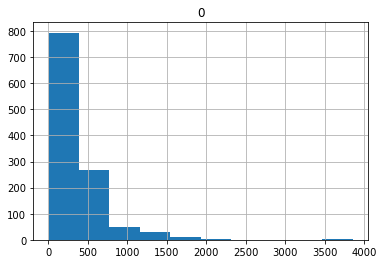

In [13]:
a = length_1.hist()
plt.show(a)

In [14]:

length_1 = DataFrame()

for i,j in enumerate(np.array(morphsVectored[(int(len(morphsVectored) / 2)) + 1 : len(morphsVectored)])):
    good = DataFrame([len(j)],index=[i])
    length_1 = pd.concat([length_1,good],axis=0)

C:\Users\23\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


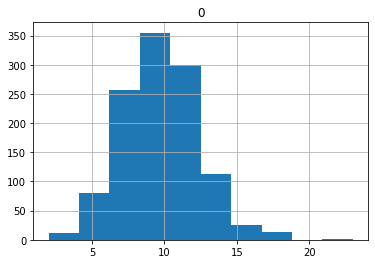

In [15]:
a = length_1.hist()
plt.show(a)

In [ ]:
# text classification
target = pd.get_dummies(DataFrame(target)).reset_index(drop = True)

input_1 = sequence.pad_sequences(morphsVectored ,maxlen = 70)

X_train, X_test, y_train, y_test = train_test_split(input_1, target ,test_size=0.25)
#y_train = np_utils.to_categorical(y_train)
#y_test = np_utils.to_categorical(y_test)

In [12]:
# text generating

input_1 = sequence.pad_sequences(morphsVectored[1 : (int(len(morphsVectored) / 2))],maxlen = 1000,
                                padding = 'post',
                                truncating = 'post')

input_2 = sequence.pad_sequences(morphsVectored[(int(len(morphsVectored) / 2)) + 1 : len(morphsVectored)],maxlen = 20,
                                 padding = 'post',
                                truncating = 'post')

X_train_1,X_val_1,X_train_2,X_val_2 = train_test_split(input_1, input_2 ,test_size=0.25)
#y_train = np_utils.to_categorical(y_train)
#y_test = np_utils.to_categorical(y_test)

dummies_temp = DataFrame(columns = [i for i in range(0,len(vocabulary) + 1)])

## 3. 모델 구성

In [13]:
# Positioning Encoding 생성 함수

def get_timing_signal_1d(length,
                         channels,
                         min_timescale=1.0,
                         max_timescale=1.0e4,
                         start_index=0):
    position = tf.cast(tf.range(length) + start_index,dtype=tf.float32)
    num_timescales = channels // 2
    log_timescale_increment = (
        math.log(float(max_timescale) / float(min_timescale)) /
        (tf.cast(num_timescales, dtype=tf.float32) - 1))
    inv_timescales = min_timescale * tf.exp(
        tf.cast(tf.range(num_timescales),dtype=tf.float32) * -log_timescale_increment)
    scaled_time = tf.expand_dims(position, 1) * tf.expand_dims(inv_timescales, 0)
    signal = tf.concat([tf.sin(scaled_time), tf.cos(scaled_time)], axis=1)
    signal = tf.pad(signal, [[0, 0], [0, tf.math.floormod(channels, 2)]])
    signal = tf.reshape(signal, [1, length, channels])
    return signal

# 패딩 마스크 생성 함수

def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

    # add extra dimensions to add the padding
    # to the attention logits.
    return seq[:, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

#미리보기 마스크 생성 함수

def create_look_ahead_mask(size):
    # 단어 순서에 따라 상삼각행렬을 만들어준다.
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

### 1) 파라미터

In [16]:
# text_classification

multi_head_num = 8
encoder_num = 5
decoder_num = 5
vocab_size = len(vocabulary) + 1
target_size = target.shape[1]
embedding_dim = 300
dense_dim = 100

sen_len_1 = input_1[0].shape[0]
sen_len_2 = input_1[0].shape[0]

In [14]:
#text_generating

multi_head_num = 8
encoder_num = 3
decoder_num = 3
vocab_size = len(vocabulary) + 1
target_size = len(vocabulary) + 1
embedding_dim = 300
dense_dim = 100

sen_len_1 = input_1[0].shape[0]
sen_len_2 = input_2[0].shape[0] - 1

### 2)입력 구성

In [15]:
## input_1 ##

input_vec_1 = layers.Input([sen_len_1])
c_embedding = layers.Embedding(vocab_size, embedding_dim)(input_vec_1)

position_encoding = layers.Lambda(lambda x : 
                                      get_timing_signal_1d(length = int(x.shape[1]), 
                                                           channels = int(x.shape[2])))(c_embedding)

c_embedding = layers.Lambda(lambda x :
                           x[0] + x[1])([c_embedding,position_encoding])

In [16]:
## input_2 ##

input_vec_2 = layers.Input([sen_len_2])
o_embedding = layers.Embedding(vocab_size, embedding_dim)(input_vec_2)

position_encoding = layers.Lambda(lambda x : 
                                      get_timing_signal_1d(length = int(x.shape[1]), 
                                                           channels = int(x.shape[2])))(o_embedding)
    
o_embedding = layers.Lambda(lambda x :
                           x[0] + x[1])([o_embedding,position_encoding])

### 3) Transformer 모델 구성

#### (1)encoder

In [17]:
for i in range(0, encoder_num):
    print(i)

    if i == 0:
        queries = layers.Dense(dense_dim)(c_embedding)
        keys = layers.Dense(dense_dim)(c_embedding)
        values = layers.Dense(dense_dim)(c_embedding)
        
        query_key = layers.Dot(axes = 2)([queries,keys])
        query_key = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key)
        query_key = layers.Lambda(lambda x : x + (create_padding_mask(input_vec_1) * (-1e9)))(query_key)
        query_key = layers.Softmax()(query_key)
        
        attention = layers.Dot(axes=1)([query_key,values])
        
        for j in range(0 ,(multi_head_num - 1)):
            queries_n = layers.Dense(dense_dim)(c_embedding)
            keys_n = layers.Dense(dense_dim)(c_embedding)
            values_n = layers.Dense(dense_dim)(c_embedding)

            query_key_n = layers.Dot(axes = 2)([queries_n,keys_n])
            query_key_n = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key_n)
            query_key_n = layers.Lambda(lambda x : x + (create_padding_mask(input_vec_1) * (-1e9)))(query_key_n)
            query_key_n = layers.Softmax()(query_key_n)

            attention_n = layers.Dot(axes=1)([query_key_n,values_n])

            attention = layers.Concatenate()([attention,attention_n])
            
        attention_head = layers.Dense(embedding_dim)(attention)

        encoder_resnet = layers.Add()([c_embedding,attention_head])
        encoder_resnet = layers.BatchNormalization()(encoder_resnet)

        encoder_output_resnet = layers.Dense(embedding_dim)(encoder_resnet)
        encoder_output_resnet = layers.Add()([encoder_output_resnet, encoder_resnet])
        encoder_output_resnet = layers.BatchNormalization()(encoder_output_resnet)
        
    else :
        
        quries = layers.Dense(dense_dim)(encoder_output_resnet)
        keys = layers.Dense(dense_dim)(encoder_output_resnet)
        values = layers.Dense(dense_dim)(encoder_output_resnet)

        query_key = layers.Dot(axes = 2)([queries,keys])
        query_key = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key)
        query_key = layers.Lambda(lambda x : x + (create_padding_mask(input_vec_1) * (-1e9)))(query_key)
        query_key = layers.Softmax()(query_key)

        attention = layers.Dot(axes=1)([query_key,values])

        for j in range(0 ,(multi_head_num - 1)):
            queries_n = layers.Dense(dense_dim)(encoder_output_resnet)
            keys_n = layers.Dense(dense_dim)(encoder_output_resnet)
            values_n = layers.Dense(dense_dim)(encoder_output_resnet)

            query_key_n = layers.Dot(axes = 2)([queries_n,keys_n])
            query_key_n = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key_n)
            query_key_n = layers.Lambda(lambda x : x + (create_padding_mask(input_vec_1) * (-1e9)))(query_key_n)
            query_key_n = layers.Softmax()(query_key_n)

            attention_n = layers.Dot(axes=1)([query_key_n,values_n])

            attention = layers.Concatenate()([attention,attention_n])

        attention_head = layers.Dense(embedding_dim)(attention)

        encoder_resnet = layers.Add()([encoder_output_resnet,attention_head])
        encoder_resnet = layers.BatchNormalization()(encoder_resnet)

        encoder_output_resnet = layers.Dense(embedding_dim)(encoder_resnet)
        encoder_output_resnet = layers.Add()([encoder_output_resnet, encoder_resnet])
        encoder_output_resnet = layers.BatchNormalization()(encoder_output_resnet)

0
1
2


#### (2) Decoder

In [19]:
 for i in range(0, decoder_num):
    
    print(i)    
    
    ## first floor decoder
    
    if i == 0 :    
        queries = layers.Dense(dense_dim)(o_embedding)
        keys = layers.Dense(dense_dim)(o_embedding)
        values = layers.Dense(dense_dim)(o_embedding)

        query_key = layers.Dot(axes = 2)([keys,queries])
        query_key = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key)
        combined_mask = tf.maximum((create_look_ahead_mask(input_vec_2.shape[1]) * (-1e9)), 
                   (create_padding_mask(input_vec_2) * (-1e9)))
        query_key = layers.Lambda(lambda x : x + combined_mask)(query_key)
        query_key = layers.Softmax()(query_key)
        
        attention = layers.Dot(axes=1)([query_key,values])
        
        for j in range(0 ,(multi_head_num - 1)):
            
            queries_n = layers.Dense(dense_dim)(o_embedding)
            keys_n = layers.Dense(dense_dim)(o_embedding)
            values_n = layers.Dense(dense_dim)(o_embedding)

            query_key_n = layers.Dot(axes = 2)([keys_n,queries_n])
            query_key_n = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key_n)
            query_key_n = layers.Lambda(lambda x : x + combined_mask)(query_key_n)
            query_key_n = layers.Softmax()(query_key_n)

            attention_n = layers.Dot(axes=1)([query_key_n,values_n])

            attention = layers.Concatenate()([attention,attention_n])

        attention_head = layers.Dense(embedding_dim)(attention)

        decoder_resnet = layers.Add()([o_embedding,attention_head])
        decoder_resnet = layers.BatchNormalization()(decoder_resnet)

        decoder_output_resnet = layers.Dense(embedding_dim)(decoder_resnet)
        decoder_output_resnet = layers.Add()([decoder_output_resnet, decoder_resnet])
        decoder_output_resnet = layers.BatchNormalization()(decoder_output_resnet)
        
        queries = layers.Dense(dense_dim)(decoder_output_resnet)
        keys = layers.Dense(dense_dim)(encoder_output_resnet)
        values = layers.Dense(dense_dim)(encoder_output_resnet)
        
        query_key = layers.Dot(axes = 2)([keys,queries])
        query_key = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key)
        query_key = layers.Lambda(lambda x : x + (create_padding_mask(input_vec_2) * (-1e9)))(query_key)                           
        query_key = layers.Softmax()(query_key)
        
        attention = layers.Dot(axes=1)([query_key,values])

        for j in range(0 ,(multi_head_num - 1)):
            queries_n = layers.Dense(dense_dim)(decoder_output_resnet)
            keys_n = layers.Dense(dense_dim)(encoder_output_resnet)
            values_n = layers.Dense(dense_dim)(encoder_output_resnet)

            query_key_n = layers.Dot(axes = 2)([keys_n,queries_n])
            query_key_n = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key_n)
            query_key_n = layers.Lambda(lambda x : x + (create_padding_mask(input_vec_2) * (-1e9)))(query_key_n)                       
            query_key_n = layers.Softmax()(query_key_n)

            attention_n = layers.Dot(axes=1)([query_key_n,values_n])

            attention = layers.Concatenate()([attention,attention_n])

        attention_head = layers.Dense(embedding_dim)(attention)

        decoder_resnet = layers.Add()([decoder_output_resnet,attention_head])
        decoder_resnet = layers.BatchNormalization()(decoder_resnet)

        decoder_output_resnet = layers.Dense(embedding_dim)(decoder_resnet)
        decoder_output_resnet = layers.Add()([decoder_output_resnet, decoder_resnet])
        decoder_output_resnet = layers.BatchNormalization()(decoder_output_resnet)
        
    else:
        
              ## n-th floor decoder  
        
        queries = layers.Dense(dense_dim)(decoder_output_resnet)
        keys = layers.Dense(dense_dim)(decoder_output_resnet)
        values = layers.Dense(dense_dim)(decoder_output_resnet)

        query_key = layers.Dot(axes = 2)([keys,queries])
        query_key = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key)
        combined_mask = tf.maximum((create_look_ahead_mask(input_vec_2.shape[1]) * (-1e9)), 
           (create_padding_mask(input_vec_2) * (-1e9)))
        query_key = layers.Lambda(lambda x : x + combined_mask)(query_key)                           
        query_key = layers.Softmax()(query_key)
        
        attention = layers.Dot(axes=1)([query_key,values])
        
        for j in range(0 ,(multi_head_num - 1)):
            
            queries_n = layers.Dense(dense_dim)(decoder_output_resnet)
            keys_n = layers.Dense(dense_dim)(decoder_output_resnet)
            values_n = layers.Dense(dense_dim)(decoder_output_resnet)

            query_key_n = layers.Dot(axes = 2)([keys_n,queries_n])
            query_key_n = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key_n)
            query_key_n = layers.Lambda(lambda x : x + combined_mask)(query_key_n)                       
            query_key_n = layers.Softmax()(query_key_n)

            attention_n = layers.Dot(axes=1)([query_key_n,values_n])

            attention = layers.Concatenate()([attention,attention_n])

        attention_head = layers.Dense(embedding_dim)(attention)

        decoder_resnet = layers.Add()([decoder_output_resnet,attention_head])
        decoder_resnet = layers.BatchNormalization()(decoder_resnet)

        decoder_output_resnet = layers.Dense(embedding_dim)(decoder_resnet)
        decoder_output_resnet = layers.Add()([decoder_output_resnet, decoder_resnet])
        decoder_output_resnet = layers.BatchNormalization()(decoder_output_resnet)
        
        queries = layers.Dense(dense_dim)(decoder_output_resnet)
        keys = layers.Dense(dense_dim)(encoder_output_resnet)
        values = layers.Dense(dense_dim)(encoder_output_resnet)
        
        query_key = layers.Dot(axes = 2)([keys,queries])
        query_key = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key)
        query_key = layers.Lambda(lambda x : x + (create_padding_mask(input_vec_2) * (-1e9)))(query_key)                           
        query_key = layers.Softmax()(query_key)

        attention = layers.Dot(axes=1)([query_key,values])

        for j in range(0 ,(multi_head_num - 1)):
            queries_n = layers.Dense(dense_dim)(decoder_output_resnet)
            keys_n = layers.Dense(dense_dim)(encoder_output_resnet)
            values_n = layers.Dense(dense_dim)(encoder_output_resnet)

            query_key_n = layers.Dot(axes = 2)([keys_n,queries_n])
            query_key_n = layers.Lambda(lambda x: (x / np.sqrt(dense_dim)))(query_key_n)
            query_key_n = layers.Lambda(lambda x : x + (create_padding_mask(input_vec_2) * (-1e9)))(query_key_n)                       
            query_key_n = layers.Softmax()(query_key_n)

            attention_n = layers.Dot(axes=1)([query_key_n,values_n])

            attention = layers.Concatenate()([attention,attention_n])

        attention_head = layers.Dense(embedding_dim)(attention)

        decoder_resnet = layers.Add()([decoder_output_resnet,attention_head])
        decoder_resnet = layers.BatchNormalization()(decoder_resnet)

        decoder_output_resnet = layers.Dense(embedding_dim)(decoder_resnet)
        decoder_output_resnet = layers.Add()([decoder_output_resnet, decoder_resnet])
        decoder_output_resnet = layers.BatchNormalization()(decoder_output_resnet)

0
1
2


#### (3) 출력 및 모델 결합

In [ ]:
# text_classification

output_vec = layers.GlobalAveragePooling1D()(decoder_output_resnet)

output_vec = layers.Dense(output_vec.shape[1])(output_vec)

output_vec = layers.Dense(target_size, activation="softmax")(output_vec)

transformer = Model(inputs = [input_vec_1,input_vec_2], outputs = [output_vec])

In [20]:
# text generating

output_vec = layers.Dense(target_size,activation="softmax")(decoder_output_resnet)

#output_vec = layers.Lambda(lambda x : x[:,0,:])(output_vec)

transformer = Model(inputs = [input_vec_1,input_vec_2], outputs = [output_vec])

#### (4) 시각화

In [23]:
transformer.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 300)    5054700     input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (1, 1000, 300)       0           embedding_1[0][0]                
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 1000, 300)    0           embedding_1[0][0]                
                                                                 lambda_1[0][0]             

                                                                 dense_198[0][0]                  
__________________________________________________________________________________________________
dense_202 (Dense)               (None, 19, 100)      30100       batch_normalization_14[0][0]     
__________________________________________________________________________________________________
dense_201 (Dense)               (None, 19, 100)      30100       batch_normalization_14[0][0]     
__________________________________________________________________________________________________
concatenate_50 (Concatenate)    (None, 19, 200)      0           dot_114[0][0]                    
                                                                 dot_116[0][0]                    
__________________________________________________________________________________________________
dot_118 (Dot)                   (None, 19, 100)      0           lambda_122[0][0]                 
          

## 4. 훈련 및 평가

In [21]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(patience = 3)

In [22]:
loss_object = tf.keras.losses.CategoricalCrossentropy(
    reduction = "none")

In [23]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(tf.argmax(real,axis=-1), 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return loss_

In [24]:
def accuracy_function(real, pred):
    accuracies = tf.equal(tf.argmax(real, axis=-1), tf.argmax(pred, axis=-1))

    mask = tf.math.logical_not(tf.math.equal(tf.argmax(real,axis=-1), 0))
    accuracies = tf.math.logical_and(mask, accuracies)

    accuracies = tf.cast(accuracies, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [25]:
transformer.compile(loss=loss_function, optimizer="adam", metrics = [accuracy_function])

In [35]:
#transformer.save("tranformer_cls.h5")
#transformer.save("tranformer.h5")
transformer.load_weights("tranformer.h5")

In [ ]:
#text_classification

    transformer.fit([X_train, X_train] , 
                    y_train ,
                    epochs=50,
                    batch_size = 5, 
                    validation_data = ([X_test, X_test], y_test),
                    callbacks = [early_stopping]
                   )

In [26]:
#text_generating

zero_or_one = input("있는 벡터화 쓸까요(0), 아님 신규로 만들까요(1)")

if zero_or_one == 1:

    temp = [dummies_temp.merge(
                pd.get_dummies(j), 
                how = "outer").fillna(0)
                for j in X_val_2]

    y_test = np.array([j[np.sort(j.columns)] 
                for j in temp])
    
    np.save("y_test.npy",y_test)
    
else :
    y_test = np.load("y_test.npy")

있는 벡터화 쓸까요(0), 아님 신규로 만들까요(1)0


In [ ]:
for i in range(1,19) :
    temp = [dummies_temp.merge(
            pd.get_dummies(j), 
            how = "outer").fillna(0)
            for j in X_train_2[(100 * i) : (100 * i) + 100]]

    y_train = np.array([j[np.sort(j.columns)] 
               for j in temp])
    
    #j = np.random.randint(11,200) - 10
    
    #X_val_1_reshape = X_val_1[j].reshape((1,X_val_1[j].shape[0]))
    #X_val_2_reshape = X_val_2[j].reshape((12.,X_val_2[j].shape[0]))
    

    transformer.fit([X_train_1[(100 * i) : (100 * i) + 100], X_train_2[(100 * i) : (100 * i) + 100, 0 : 19]] , 
                    y_train[:, 1:20, :] ,
                    epochs=50,
                    batch_size = 10, 
                    validation_data = ([X_val_1, X_val_2[: , 0:19]], y_test[:, 1:20, :]),
                    #callbacks = [early_stopping]
                   )

In [1005]:
start_list = [vocabulary['CLS']]

start_list.extend([0 for i in range(0,sen_len_2 - 1)])

In [1006]:
start_list = [start_list for i in range(0,5)]
start_list = np.array(start_list)

In [ ]:
for i in range(1,19) :
    print(i)
    pred = transformer.predict([X_train_1[0:5],start_list])
    start_list[:, i] = np.argmax(pred[:,i,:], axis = 1)

In [ ]:
start_list

In [ ]:
for i in start_list[1]:
    if np.any(np.array(list(vocabulary.values()) == i)) == False :
        continue
    idx = list(vocabulary.keys())[int(np.where(np.array(list(vocabulary.values())) == i)[0])]
    print(idx)